In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import numpy as np
import re
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt  # Added for plotting
from nltk.stem import WordNetLemmatizer
import optuna
import pandas as pd
import pickle
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
import torch.nn.functional as F

c:\Users\Admin\Desktop\SC4002_Natural-Language-Processing_Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_glove = load_glove_embeddings('glove_files/glove.6B.300d.txt')


In [4]:
embedding_dim = 300
embeddings_glove['<pad>'] = np.zeros(embedding_dim)
embeddings_glove['<unk>'] = np.random.normal(size = embedding_dim) #follow pytorch default initialization

In [5]:
with open(r'C:\Users\Admin\Desktop\SC4002_Natural-Language-Processing_Project\embedding_dictionary_wo_unkns.pkl', 'rb') as f:
    embedding_dict = pickle.load(f)

In [6]:
with open(r'C:\Users\Admin\Desktop\SC4002_Natural-Language-Processing_Project\wo_unk_final_dictionary.pkl', 'rb') as f:
    embedding_test = pickle.load(f)
#embedding_test['<unk>']

In [7]:
#find overlapping keys in both dictionaries
common_keys = set(embeddings_glove.keys()) & set(embedding_dict.keys())
print(common_keys)
print(len(embeddings_glove))
print(len(embedding_dict))
print(len(common_keys))


{'hollywood', 'else', 'class', 'old-world', 'four', 'black', 'a', 'girl', 'white', 'woman', 'stunning', 'after', 'less', 'fill-in', 'hard', 'low', 'self', 'television', 'adapted', 'super', 'double', 'west', 're', 'character', 'heidegger', 'off', 'witch', 'weirded', 'inevitable', 'and', 'hit', 'rambo'}
400002
1514
32


In [8]:
#merge both dicts, keeping the values from the glove embeddings
final_dict = {**embedding_dict, **embeddings_glove}
print(len(final_dict))

401484


In [9]:
import pickle
#with open('wo_unk_final_dictionary.pkl', 'wb') as f:
    #pickle.dump(final_dict, f)

In [10]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

print(train_dataset[0])

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


# Part 1a

In [11]:
counter = Counter()
for example in train_dataset:
    tokens = word_tokenize(example['text'])
    counter.update(tokens)

# Vocabulary is the set of unique words
vocab = set(counter.keys())
vocab_size = len(vocab)

print("Size of the vocabulary:", vocab_size)

Size of the vocabulary: 18030


# Part 1b

In [12]:
#count the number of words in train dataset that are not in the glove embeddings
count = 0
for word in vocab:
    if word not in embeddings_glove:
        count += 1
print(count)




1867


# Part 2

In [13]:
class RTDataset(Dataset):
    def __init__(self, dataset, vocab):
        self.dataset = dataset
        self.vocab = vocab
        self.tokenizer = word_tokenize
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        tokens = self.tokenizer(text)
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        return torch.tensor(indices, dtype=torch.long).to(device), torch.tensor(label, dtype=torch.long).to(device)

In [14]:
# Create word-to-index and index-to-word mappings
vocab = {}
index = 0
for word, emb in embeddings_glove.items():
    #print(word)
    vocab[word] = index
    index += 1
len(vocab)

400002

In [15]:
embedding_matrix = np.zeros((len(embeddings_glove), embedding_dim))


for word, idx in vocab.items():

    embedding_matrix[idx] = embeddings_glove[word]

print(embedding_matrix.shape)

(400002, 300)


In [13]:
def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in texts], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<pad>'])
    return texts_padded.to(device), labels.to(device), lengths.to(device)

# Create datasets and dataloaders
batch_size = 128

train_data = RTDataset(train_dataset, vocab)
valid_data = RTDataset(validation_dataset, vocab)
test_data = RTDataset(test_dataset, vocab)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix ,bidirectional=False):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        output = self.fc(hidden)
        return output

# Instantiate the model, loss function, and optimizer
hidden_dim = 128
output_dim = 2  # Negative or Positive sentiment

model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.00015370745883403421)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


# Training and evaluation functions
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_acc, total_loss = 0, 0
    for texts, labels, lengths in dataloader:
        #print(texts.device, labels.device, lengths.device)
        
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_acc += (outputs.argmax(1) == labels).sum().item()
        total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for texts, labels, lengths in dataloader:
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

# Training loop
num_epochs = 50
epoch_count = 0
early_stopping = EarlyStopping(patience=10, delta=0.01)
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    early_stopping(valid_loss, model)

    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')
    epoch_count += 1
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluate on the test set
early_stopping.load_best_model(model)
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Epoch 1:
    Train Loss: 0.6846, Train Acc: 0.5540
    Val Loss: 0.6656, Val Acc: 0.5976
Epoch 2:
    Train Loss: 0.6166, Train Acc: 0.6654
    Val Loss: 0.5722, Val Acc: 0.7111
Epoch 3:
    Train Loss: 0.5346, Train Acc: 0.7348
    Val Loss: 0.5263, Val Acc: 0.7317
Epoch 4:
    Train Loss: 0.5081, Train Acc: 0.7506
    Val Loss: 0.5269, Val Acc: 0.7402
Epoch 5:
    Train Loss: 0.5006, Train Acc: 0.7590
    Val Loss: 0.5061, Val Acc: 0.7373
Epoch 6:
    Train Loss: 0.4894, Train Acc: 0.7669
    Val Loss: 0.5135, Val Acc: 0.7345
Epoch 7:
    Train Loss: 0.4848, Train Acc: 0.7681
    Val Loss: 0.5057, Val Acc: 0.7552
Epoch 8:
    Train Loss: 0.4791, Train Acc: 0.7751
    Val Loss: 0.5050, Val Acc: 0.7467
Epoch 9:
    Train Loss: 0.4809, Train Acc: 0.7694
    Val Loss: 0.4992, Val Acc: 0.7552
Epoch 10:
    Train Loss: 0.4717, Train Acc: 0.7782
    Val Loss: 0.5062, Val Acc: 0.7486
Epoch 11:
    Train Loss: 0.4671, Train Acc: 0.7802
    Val Loss: 0.4968, Val Acc: 0.7514
Epoch 12:
    Train

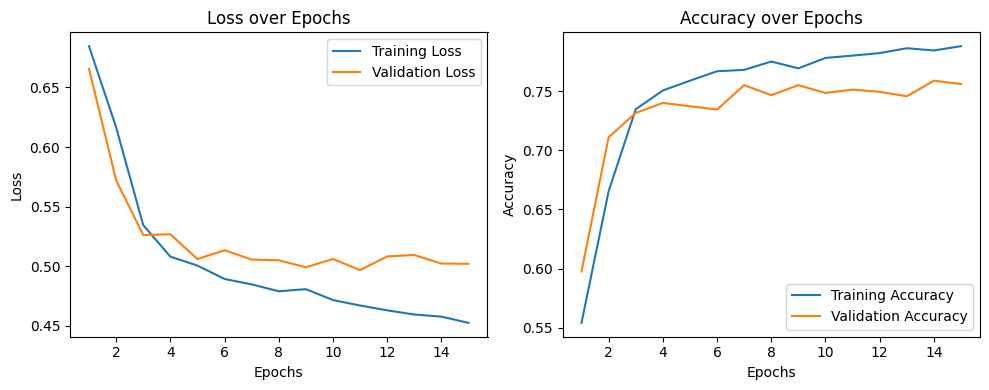

In [14]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1,epoch_count + 1), train_losses, label='Training Loss')
plt.plot(range(1, epoch_count + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_count + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epoch_count + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Define the objective function for Optuna
def objective(trial):
    
    # Suggest hyperparameters
    hidden_dim = trial.suggest_int('hidden_dim', 64, 512, step=64)
    bidirectional = trial.suggest_categorical('bidirectional', [False, True])
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create datasets and dataloaders with the suggested batch size
    train_data = RTDataset(train_dataset, vocab)
    valid_data = RTDataset(validation_dataset, vocab)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize the model, criterion, and optimizer with the suggested hyperparameters
    output_dim = 2  # Negative or Positive sentiment
    model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        train_acc, train_loss = train(model, train_loader, optimizer, criterion)
        valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
        # Optuna requires a numerical value to minimize (or maximize)
        trial.report(valid_loss, epoch)
        # Handle pruning (optional)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return valid_loss  # We aim to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {:.4f}'.format(trial.value))
print('  Params:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-11-01 16:25:03,011] A new study created in memory with name: no-name-cc40ff82-ff9d-4703-b490-c6c0e2b42500
C:\Users\Admin\AppData\Local\Temp\ipykernel_59116\3482628209.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
[I 2024-11-01 16:26:43,535] Trial 0 finished with value: 0.7199929317435002 and parameters: {'hidden_dim': 64, 'bidirectional': False, 'lr': 0.06912902749024018, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.7199929317435002.
[I 2024-11-01 16:28:15,140] Trial 1 finished with value: 0.6770277928008819 and parameters: {'hidden_dim': 384, 'bidirectional': True, 'lr': 0.0010355876590209508, 'batch_size': 64, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.6770277928008819.
[I 2024-11-01 16:29:45,238] Trial 2 finished with value: 1.0568

Number of finished trials: 20
Best trial:
  Value: 0.4892
  Params:
    hidden_dim: 128
    bidirectional: False
    lr: 0.00015370745883403421
    batch_size: 128
    optimizer: Adam


# 2 c

max of hidden

In [16]:

# Define the RNN model
class RNNModel_c(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix ,bidirectional=False):
        super(RNNModel_c, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        #use the max of the hidden states
        hidden, _ = torch.max(hidden, dim=0)
        #hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        output = self.fc(hidden)
        return output

# Instantiate the model, loss function, and optimizer
hidden_dim = 128
output_dim = 2  # Negative or Positive sentiment

model = RNNModel_c(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.00015370745883403421)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Create datasets and dataloaders
batch_size = 128
# Training loop
num_epochs = 50
epoch_count = 0
early_stopping = EarlyStopping(patience=10, delta=0.01)
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    early_stopping(valid_loss, model)

    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')
    epoch_count += 1
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluate on the test set
early_stopping.load_best_model(model)
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Epoch 1:
    Train Loss: 0.6860, Train Acc: 0.5523
    Val Loss: 0.6731, Val Acc: 0.5816
Epoch 2:
    Train Loss: 0.6283, Train Acc: 0.6562
    Val Loss: 0.5664, Val Acc: 0.7083
Epoch 3:
    Train Loss: 0.5345, Train Acc: 0.7359
    Val Loss: 0.5448, Val Acc: 0.7326
Epoch 4:
    Train Loss: 0.5083, Train Acc: 0.7586
    Val Loss: 0.5280, Val Acc: 0.7392
Epoch 5:
    Train Loss: 0.5020, Train Acc: 0.7612
    Val Loss: 0.5093, Val Acc: 0.7542
Epoch 6:
    Train Loss: 0.4880, Train Acc: 0.7694
    Val Loss: 0.5123, Val Acc: 0.7514
Epoch 7:
    Train Loss: 0.4876, Train Acc: 0.7675
    Val Loss: 0.5020, Val Acc: 0.7570
Epoch 8:
    Train Loss: 0.4783, Train Acc: 0.7741
    Val Loss: 0.5032, Val Acc: 0.7523
Epoch 9:
    Train Loss: 0.4774, Train Acc: 0.7746
    Val Loss: 0.4994, Val Acc: 0.7552
Epoch 10:
    Train Loss: 0.4760, Train Acc: 0.7739
    Val Loss: 0.5033, Val Acc: 0.7533
Epoch 11:
    Train Loss: 0.4686, Train Acc: 0.7792
    Val Loss: 0.4954, Val Acc: 0.7636
Epoch 12:
    Train

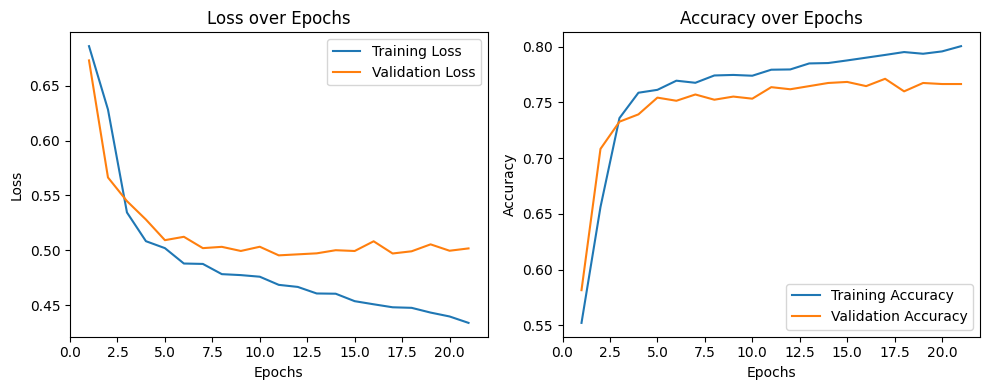

In [17]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1,epoch_count + 1), train_losses, label='Training Loss')
plt.plot(range(1, epoch_count + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_count + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epoch_count + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

mean of hidden

In [18]:
# Define the RNN model
class RNNModel_c_mean(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix ,bidirectional=False):
        super(RNNModel_c_mean, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        #use the mean of the hidden states
        hidden = torch.mean(hidden, dim=0)
        #hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        output = self.fc(hidden)
        return output

# Instantiate the model, loss function, and optimizer
hidden_dim = 128
output_dim = 2  # Negative or Positive sentiment

model = RNNModel_c_mean(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.00015370745883403421)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Create datasets and dataloaders
batch_size = 128
# Training loop
num_epochs = 50
epoch_count = 0
early_stopping = EarlyStopping(patience=10, delta=0.01)
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    early_stopping(valid_loss, model)

    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')
    epoch_count += 1
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluate on the test set
early_stopping.load_best_model(model)
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1:
    Train Loss: 0.6751, Train Acc: 0.5798
    Val Loss: 0.6543, Val Acc: 0.6163
Epoch 2:
    Train Loss: 0.5912, Train Acc: 0.6920
    Val Loss: 0.5590, Val Acc: 0.7158
Epoch 3:
    Train Loss: 0.5276, Train Acc: 0.7442
    Val Loss: 0.5160, Val Acc: 0.7486
Epoch 4:
    Train Loss: 0.5059, Train Acc: 0.7529
    Val Loss: 0.5153, Val Acc: 0.7439
Epoch 5:
    Train Loss: 0.4961, Train Acc: 0.7613
    Val Loss: 0.5047, Val Acc: 0.7495
Epoch 6:
    Train Loss: 0.4873, Train Acc: 0.7682
    Val Loss: 0.4997, Val Acc: 0.7523
Epoch 7:
    Train Loss: 0.4805, Train Acc: 0.7742
    Val Loss: 0.5122, Val Acc: 0.7514
Epoch 8:
    Train Loss: 0.4759, Train Acc: 0.7775
    Val Loss: 0.5024, Val Acc: 0.7608
Epoch 9:
    Train Loss: 0.4700, Train Acc: 0.7780
    Val Loss: 0.5121, Val Acc: 0.7561
Epoch 10:
    Train Loss: 0.4690, Train Acc: 0.7788
    Val Loss: 0.4908, Val Acc: 0.7655
Epoch 11:
    Train Loss: 0.4628, Train Acc: 0.7824
    Val Loss: 0.5116, Val Acc: 0.7523
Epoch 12:
    Train

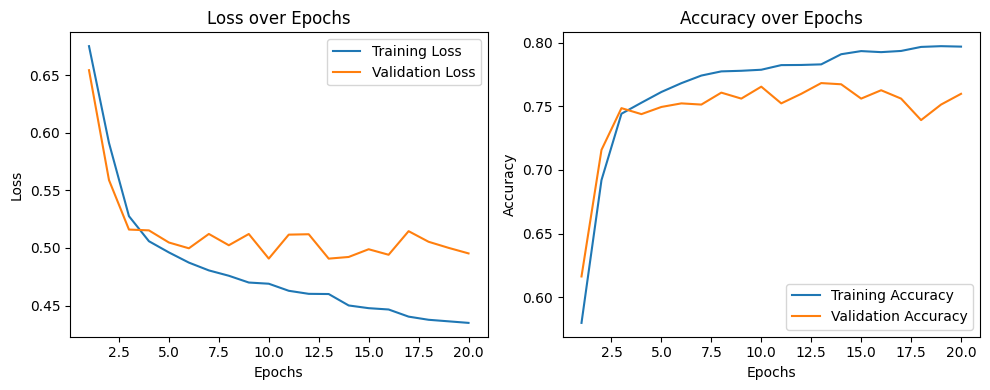

In [19]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1,epoch_count + 1), train_losses, label='Training Loss')
plt.plot(range(1, epoch_count + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_count + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epoch_count + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

min of hidden

In [20]:
# Define the RNN model
class RNNModel_min(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix ,bidirectional=False):
        super(RNNModel_min, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        #use the minimum of the hidden states
        hidden, _ = torch.min(hidden, dim=0)

        #hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        output = self.fc(hidden)
        return output

# Instantiate the model, loss function, and optimizer
hidden_dim = 128
output_dim = 2  # Negative or Positive sentiment

model = RNNModel_min(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.00015370745883403421)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Create datasets and dataloaders
batch_size = 128
# Training loop
num_epochs = 50
epoch_count = 0
early_stopping = EarlyStopping(patience=10, delta=0.01)
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    early_stopping(valid_loss, model)

    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')
    epoch_count += 1
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluate on the test set
early_stopping.load_best_model(model)
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1:
    Train Loss: 0.6812, Train Acc: 0.5644
    Val Loss: 0.6627, Val Acc: 0.6032
Epoch 2:
    Train Loss: 0.5971, Train Acc: 0.6802
    Val Loss: 0.5449, Val Acc: 0.7289
Epoch 3:
    Train Loss: 0.5206, Train Acc: 0.7469
    Val Loss: 0.5162, Val Acc: 0.7477
Epoch 4:
    Train Loss: 0.5043, Train Acc: 0.7590
    Val Loss: 0.5160, Val Acc: 0.7448
Epoch 5:
    Train Loss: 0.4937, Train Acc: 0.7652
    Val Loss: 0.5051, Val Acc: 0.7495
Epoch 6:
    Train Loss: 0.4933, Train Acc: 0.7603
    Val Loss: 0.5013, Val Acc: 0.7552
Epoch 7:
    Train Loss: 0.4773, Train Acc: 0.7757
    Val Loss: 0.4970, Val Acc: 0.7505
Epoch 8:
    Train Loss: 0.4748, Train Acc: 0.7735
    Val Loss: 0.4924, Val Acc: 0.7664
Epoch 9:
    Train Loss: 0.4704, Train Acc: 0.7802
    Val Loss: 0.5068, Val Acc: 0.7589
Epoch 10:
    Train Loss: 0.4740, Train Acc: 0.7760
    Val Loss: 0.4923, Val Acc: 0.7608
Epoch 11:
    Train Loss: 0.4637, Train Acc: 0.7822
    Val Loss: 0.5055, Val Acc: 0.7608
Epoch 12:
    Train

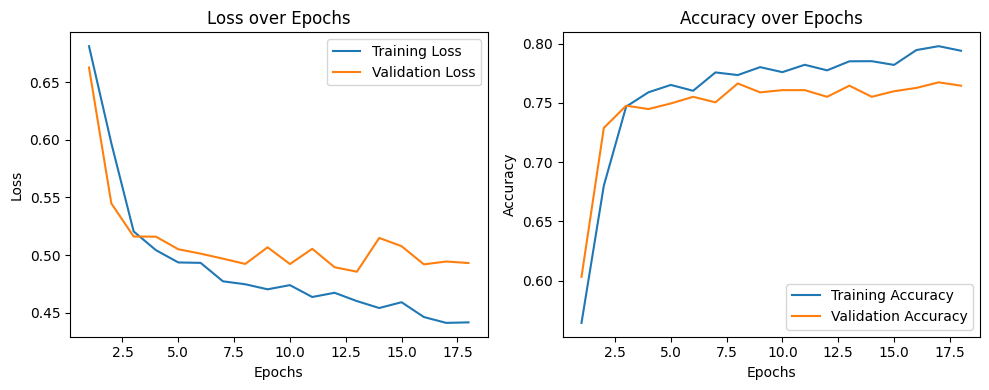

In [21]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1,epoch_count + 1), train_losses, label='Training Loss')
plt.plot(range(1, epoch_count + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_count + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epoch_count + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# 3a

Don't  freeze, use glove

In [22]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix ,bidirectional=False):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        output = self.fc(hidden)
        return output



model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)

In [24]:

# Define the RNN model

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 0.009305306006426563)


# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Create datasets and dataloaders
batch_size = 128
# Instantiate the model, loss function, and optimizer
hidden_dim = 192
output_dim = 2  # Negative or Positive sentiment

# Training loop
num_epochs = 50
epoch_count = 0
early_stopping = EarlyStopping(patience=10, delta=0.01)
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    early_stopping(valid_loss, model)

    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')
    epoch_count += 1
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluate on the test set
early_stopping.load_best_model(model)
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Epoch 1:
    Train Loss: 0.6950, Train Acc: 0.5048
    Val Loss: 0.6886, Val Acc: 0.5460
Epoch 2:
    Train Loss: 0.6912, Train Acc: 0.5254
    Val Loss: 0.6857, Val Acc: 0.5422
Epoch 3:
    Train Loss: 0.6880, Train Acc: 0.5470
    Val Loss: 0.6825, Val Acc: 0.5713
Epoch 4:
    Train Loss: 0.6849, Train Acc: 0.5611
    Val Loss: 0.6795, Val Acc: 0.5863
Epoch 5:
    Train Loss: 0.6818, Train Acc: 0.5709
    Val Loss: 0.6763, Val Acc: 0.5844
Epoch 6:
    Train Loss: 0.6783, Train Acc: 0.5791
    Val Loss: 0.6728, Val Acc: 0.5938
Epoch 7:
    Train Loss: 0.6745, Train Acc: 0.5903
    Val Loss: 0.6688, Val Acc: 0.6069
Epoch 8:
    Train Loss: 0.6701, Train Acc: 0.5981
    Val Loss: 0.6644, Val Acc: 0.6051
Epoch 9:
    Train Loss: 0.6650, Train Acc: 0.6091
    Val Loss: 0.6582, Val Acc: 0.6191
Epoch 10:
    Train Loss: 0.6576, Train Acc: 0.6170
    Val Loss: 0.6501, Val Acc: 0.6304
Epoch 11:
    Train Loss: 0.6474, Train Acc: 0.6318
    Val Loss: 0.6385, Val Acc: 0.6435
Epoch 12:
    Train

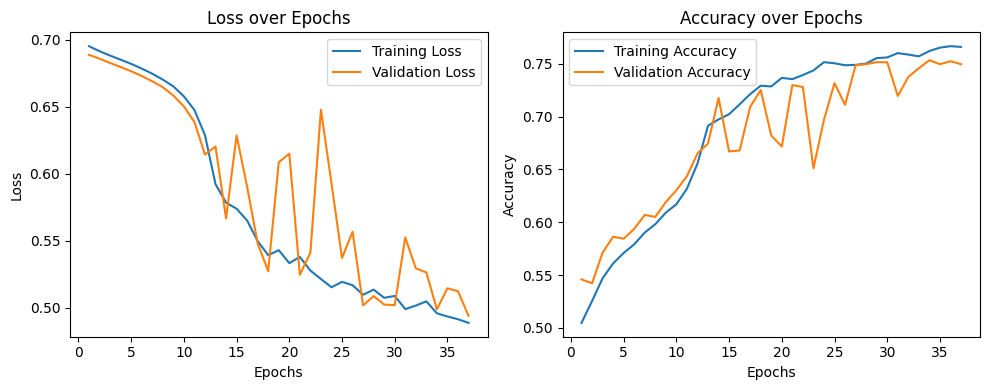

In [25]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1,epoch_count + 1), train_losses, label='Training Loss')
plt.plot(range(1, epoch_count + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_count + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epoch_count + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Looks different because stochastic gd

In [23]:
def objective(trial):
        
        # Suggest hyperparameters
        hidden_dim = trial.suggest_int('hidden_dim', 128, 512, step=64)
        #bidirectional = trial.suggest_categorical('bidirectional', [False, True])
        lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
        # Create datasets and dataloaders with the suggested batch size
        train_data = RTDataset(train_dataset, vocab)
        valid_data = RTDataset(validation_dataset, vocab)
    
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
        # Initialize the model, criterion, and optimizer with the suggested hyperparameters
        output_dim = 2  # Negative or Positive sentiment
        model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
        
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        else:
            optimizer = optim.SGD(model.parameters(), lr=lr)
    
        # Training loop
        num_epochs = 20
        for epoch in range(num_epochs):
            train_acc, train_loss = train(model, train_loader, optimizer, criterion)
            valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
            # Optuna requires a numerical value to minimize (or maximize)
            trial.report(valid_loss, epoch)
            # Handle pruning (optional)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    
        return valid_loss  # We aim to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {:.4f}'.format(trial.value))
print('  Params:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2024-11-01 18:04:55,523] A new study created in memory with name: no-name-80b17a3d-0bd8-4e0c-bc3e-6d67c57c78af
C:\Users\Admin\AppData\Local\Temp\ipykernel_66284\2293609599.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
[I 2024-11-01 18:07:07,724] Trial 0 finished with value: 1.8025258895827503 and parameters: {'hidden_dim': 320, 'lr': 0.000366775155445434, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 0 with value: 1.8025258895827503.
[I 2024-11-01 18:10:32,451] Trial 1 finished with value: 1.4616894496091088 and parameters: {'hidden_dim': 448, 'lr': 0.0018485648220132236, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 1 with value: 1.4616894496091088.
[I 2024-11-01 18:12:24,529] Trial 2 finished with value: 0.6913869621382421 and parameters: {'hidden_dim': 

Number of finished trials: 20
Best trial:
  Value: 0.5135
  Params:
    hidden_dim: 192
    lr: 0.009305306006426563
    batch_size: 128
    optimizer: SGD


In [16]:
# Create word-to-index and index-to-word mappings
vocab_new = {}
index = 0
for word, emb in final_dict.items():
    #print(word)
    vocab_new[word] = index
    index += 1
embedding_matrix_new = np.zeros((len(final_dict), embedding_dim))


for word, idx in vocab_new.items():

    embedding_matrix_new[idx] = final_dict[word]

embedding_matrix_new.shape

(401484, 300)

In [23]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [18]:
class RNNModel_new(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix ,bidirectional=False):
        super(RNNModel_new, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        output = self.fc(hidden)
        return output

# Create datasets and dataloaders
batch_size = 32
# Instantiate the model, loss function, and optimizer
hidden_dim = 512
output_dim = 2  # Negative or Positive sentiment

model = RNNModel_new(0, embedding_dim, hidden_dim, output_dim, embedding_matrix_new).to(device)

In [19]:

class RTDataset(Dataset):
    def __init__(self, dataset, vocab):
        self.dataset = dataset
        self.vocab = vocab
        self.tokenizer = word_tokenize
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        tokens = self.tokenizer(text)
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        return torch.tensor(indices, dtype=torch.long).to(device), torch.tensor(label, dtype=torch.long).to(device)

In [20]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_acc, total_loss = 0, 0
    for texts, labels, lengths in dataloader:
        #print(texts.device, labels.device, lengths.device)
        
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_acc += (outputs.argmax(1) == labels).sum().item()
        total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for texts, labels, lengths in dataloader:
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

In [21]:
vocab_size = len(vocab_new)
vocab_size

401484

In [25]:
train_data = RTDataset(train_dataset, vocab_new)
valid_data = RTDataset(validation_dataset, vocab_new)
test_data = RTDataset(test_dataset, vocab_new)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [24]:
def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in texts], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab_new['<pad>'])
    return texts_padded.to(device), labels.to(device), lengths.to(device)

In [49]:

def objective(trial):
        
        # Suggest hyperparameters
        hidden_dim = trial.suggest_int('hidden_dim', 128, 512, step=64)
        #bidirectional = trial.suggest_categorical('bidirectional', [False, True])
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
        # Create datasets and dataloaders with the suggested batch size
        train_data = RTDataset(train_dataset, vocab_new)
        valid_data = RTDataset(validation_dataset, vocab_new)
    
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
        # Initialize the model, criterion, and optimizer with the suggested hyperparameters
        output_dim = 2  # Negative or Positive sentiment
        model = RNNModel_new(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix_new)
        
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        else:
            optimizer = optim.SGD(model.parameters(), lr=lr)
    
        # Training loop
        num_epochs = 20
        for epoch in range(num_epochs):
            train_acc, train_loss = train(model, train_loader, optimizer, criterion)
            valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
            # Optuna requires a numerical value to minimize (or maximize)
            trial.report(valid_loss, epoch)
            # Handle pruning (optional)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    
        return valid_loss  # We aim to minimize validation loss

# Run the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {:.4f}'.format(trial.value))
print('  Params:')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2024-11-02 22:12:13,981] A new study created in memory with name: no-name-dd335af6-6f6a-4a2d-b2bf-55cf0b6aae6a
C:\Users\Admin\AppData\Local\Temp\ipykernel_16480\2574941710.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[W 2024-11-02 22:12:14,624] Trial 0 failed with parameters: {'hidden_dim': 448, 'lr': 5.473982230089734e-05, 'batch_size': 128, 'optimizer': 'SGD'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Admin\Desktop\SC4002_Natural-Language-Processing_Project\.venv\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_16480\2574941710.py", line 39, in objective
    train_acc, train_loss = train(model, train_

KeyboardInterrupt: 

In [27]:
train_data = RTDataset(train_dataset, vocab_new)
valid_data = RTDataset(validation_dataset, vocab_new)
test_data = RTDataset(test_dataset, vocab_new)
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [64]:
model = RNNModel_new(0, embedding_dim, hidden_dim, output_dim, embedding_matrix_new).to(device)

In [30]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 0.001)


# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []


# Training loop
num_epochs = 50
epoch_count = 0
early_stopping = EarlyStopping(patience=10, delta=0.01)
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    early_stopping(valid_loss, model)

    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')
    epoch_count += 1
    if early_stopping.early_stop:
        print("Early stopping")
        break



Epoch 1:
    Train Loss: 0.6885, Train Acc: 0.5508
    Val Loss: 0.7162, Val Acc: 0.5009
Epoch 2:
    Train Loss: 0.6814, Train Acc: 0.5589
    Val Loss: 0.7003, Val Acc: 0.5319
Epoch 3:
    Train Loss: 0.6775, Train Acc: 0.5644
    Val Loss: 0.7136, Val Acc: 0.4934
Epoch 4:
    Train Loss: 0.6773, Train Acc: 0.5647
    Val Loss: 0.7045, Val Acc: 0.5188
Epoch 5:
    Train Loss: 0.6723, Train Acc: 0.5778
    Val Loss: 0.7049, Val Acc: 0.5272
Epoch 6:
    Train Loss: 0.6696, Train Acc: 0.5810
    Val Loss: 0.7146, Val Acc: 0.5235
Epoch 7:
    Train Loss: 0.6703, Train Acc: 0.5831
    Val Loss: 0.7123, Val Acc: 0.5131
Epoch 8:
    Train Loss: 0.6728, Train Acc: 0.5753
    Val Loss: 0.7055, Val Acc: 0.5328
Epoch 9:
    Train Loss: 0.6688, Train Acc: 0.5870
    Val Loss: 0.7134, Val Acc: 0.5000
Epoch 10:
    Train Loss: 0.6660, Train Acc: 0.5872
    Val Loss: 0.7281, Val Acc: 0.5244
Epoch 11:
    Train Loss: 0.6690, Train Acc: 0.5900
    Val Loss: 0.7083, Val Acc: 0.5188
Epoch 12:
    Train

In [67]:
# Evaluate on the test set
early_stopping.load_best_model(model)
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: 0.6048, Test Acc: 0.7383


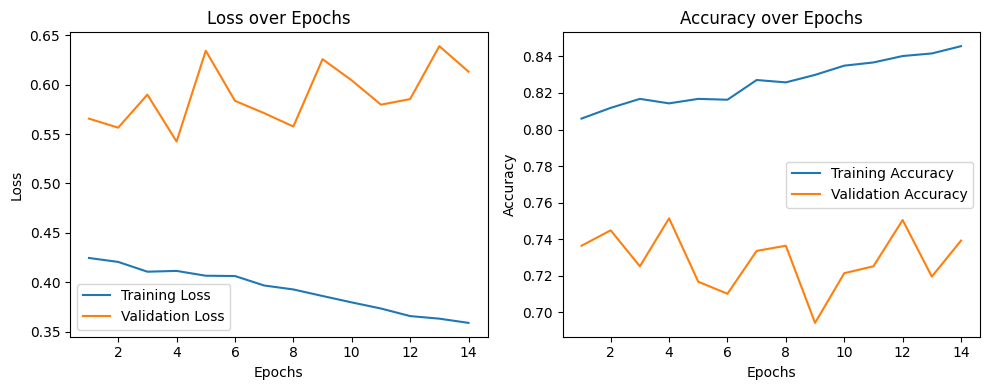

In [68]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1,epoch_count + 1), train_losses, label='Training Loss')
plt.plot(range(1, epoch_count + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch_count + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epoch_count + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# Create word-to-index and index-to-word mappings
vocab = {}
index = 0
for word, emb in final_dict.items():
    #print(word)
    vocab[word] = index
    index += 1
embedding_matrix = np.zeros((len(final_dict), embedding_dim))


for word, idx in vocab.items():

    embedding_matrix[idx] = final_dict[word]

embedding_matrix.shape

(401484, 300)

In [28]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix ,bidirectional=False):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        #use the max of the hidden states
        hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        output = self.fc(hidden)
        return output

# Instantiate the model, loss function, and optimizer
hidden_dim = 128
output_dim = 2  # Negative or Positive sentiment

model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.00010359637094187057)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Create datasets and dataloaders
batch_size =128
# Training loop
num_epochs = 50
epoch_count = 0
early_stopping = EarlyStopping(patience=10, delta=0.01)
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    early_stopping(valid_loss, model)

    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')
    epoch_count += 1
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluate on the test set
early_stopping.load_best_model(model)
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Epoch 1:
    Train Loss: 0.6954, Train Acc: 0.5165
    Val Loss: 0.6870, Val Acc: 0.5460
Epoch 2:
    Train Loss: 0.6803, Train Acc: 0.5715
    Val Loss: 0.6835, Val Acc: 0.5629
Epoch 3:
    Train Loss: 0.6682, Train Acc: 0.5842
    Val Loss: 0.6799, Val Acc: 0.5469
Epoch 4:
    Train Loss: 0.6446, Train Acc: 0.6286
    Val Loss: 0.6638, Val Acc: 0.5957
Epoch 5:
    Train Loss: 0.6071, Train Acc: 0.6732
    Val Loss: 0.6456, Val Acc: 0.6285
Epoch 6:
    Train Loss: 0.5841, Train Acc: 0.6911
    Val Loss: 0.6409, Val Acc: 0.6304
Epoch 7:
    Train Loss: 0.5457, Train Acc: 0.7225
    Val Loss: 0.6363, Val Acc: 0.6567
Epoch 8:
    Train Loss: 0.4957, Train Acc: 0.7583
    Val Loss: 0.6385, Val Acc: 0.6435
Epoch 9:
    Train Loss: 0.4482, Train Acc: 0.7876
    Val Loss: 0.6350, Val Acc: 0.6876
Epoch 10:
    Train Loss: 0.4229, Train Acc: 0.8091
    Val Loss: 0.7068, Val Acc: 0.6482
Epoch 11:
    Train Loss: 0.3659, Train Acc: 0.8411
    Val Loss: 0.7245, Val Acc: 0.6717
Epoch 12:
    Train

In [ ]:
train_data = RTDataset(train_dataset, vocab_new)
valid_data = RTDataset(validation_dataset, vocab_new)
test_data = RTDataset(test_dataset, vocab_new)
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [56]:
#check how many words in test set that are not in the vocab
counter = Counter()
for example in test_dataset:
    tokens = word_tokenize(example['text'])
    counter.update(tokens)

vocab_test = set(counter.keys())
print(len(vocab_test))

#print total number of words in the test set
total_words = 0
for example in test_dataset:
    tokens = word_tokenize(example['text'])
    total_words += len(tokens)
print(total_words)


5456
23224


In [17]:
import retrieve_embedding as remb

In [136]:
test = {'hi':1}
test.get('there') == None

True

In [18]:
class RTDataset(Dataset):
    def __init__(self, dataset, vocab):
        self.dataset = dataset
        self.vocab = vocab
        self.tokenizer = word_tokenize
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        tokens = self.tokenizer(text)
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        return torch.tensor(indices, dtype=torch.long).to(device), torch.tensor(label, dtype=torch.long).to(device)

In [52]:
class RTDataset1(Dataset):
    def __init__(self, dataset, vocab):
        self.dataset = dataset
        self.vocab = vocab
        self.tokenizer = word_tokenize
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        tokens = self.tokenizer(text)
        token_indices = []
        
        print('DONE1')
        for token in tokens:
            print('DONE2')
            cache = []
            word_exist = remb.check_existence_in_glove(token)
            if word_exist:
                cache.append(self.vocab.get(token))
                token_indices.append(cache)
            else:
                hyphen_exist = remb.check_hyphen(token)
                if hyphen_exist:
                    hyphen_words = remb.split_words(token, '-')
                    for word in hyphen_words:
                        if self.vocab.get(word) is not None:
                            cache.append(self.vocab.get(word))
                        else:
                            cache = [self.vocab.get('<unk>')]
                    token_indices.append(cache)
                else:
                    neg_prefix = remb.check_neg_prefix(token)
                    if neg_prefix is not None:
                        neg_words = remb.split_words(word, neg_prefix)
                        for word in neg_words:
                            if self.vocab.get(word) is not None:
                                cache.append(self.vocab.get(word))
                            else:
                                cache = [self.vocab.get('<unk>')]
                        token_indices.append(cache)
                    else:
                        closest_match = remb.find_best_match(token, final_dict)
                        if closest_match is not None:
                            cache.append(self.vocab.get(closest_match))
                            token_indices.append(cache)
                        else:
                            slash_exist = remb.check_slash(token)
                            if slash_exist:
                                word_list = remb.split_words(word, "/")
                                for word in word_list:
                                    if self.vocab.get(word) is not None:
                                        cache.append(self.vocab.get(word))
                                    else:
                                        cache = [self.vocab.get('<unk>')]
                                token_indices.append(cache)
                            else:
                                lemmatized_word = remb.get_lemmatized_word(word)
                                if self.vocab.get(lemmatized_word) is not None:
                                    cache.append(self.vocab.get(lemmatized_word))
                                    token_indices.append(cache)
                                else:
                                    cache = [self.vocab.get('<unk>')]
                                    token_indices.append(cache)

            



        #indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        return torch.tensor(token_indices, dtype=torch.long).to(device), torch.tensor(label, dtype=torch.long).to(device)

In [148]:
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

datasets.arrow_dataset.Dataset

In [53]:
def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in texts], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<pad>'])
    return texts_padded.to(device), labels.to(device), lengths.to(device)

valid_data1 = RTDataset1(validation_dataset, vocab)
valid_loader1 = DataLoader(valid_data1, batch_size=1, shuffle=False, collate_fn=collate_fn)






In [54]:
#get some examples with getitem
for texts, labels, lengths in valid_loader1:
    print(texts)
    print(labels)
    print(lengths)
    break

DONE1
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
DONE2
tensor([[[138676],
         [ 16795],
         [  1514],
         [  7965],
         [ 42387],
         [  2294],
         [  1629],
         [  2957],
         [  2875],
         [  2607],
         [   399],
         [  1556],
         [ 17080],
         [  3915],
         [   399],
         [ 10386],
         [  1779],
         [  1516]]], device='cuda:0')
tensor([1], device='cuda:0')
tensor([18], device='cuda:0')


In [134]:
word_tokenize('hello-world there')

['hello-world', 'there']

Epoch 1:
    Train Loss: 0.5795, Train Acc: 0.6938
    Val Loss: 0.5367, Val Acc: 0.7326
Epoch 2:
    Train Loss: 0.5227, Train Acc: 0.7451
    Val Loss: 0.5092, Val Acc: 0.7608
Epoch 3:
    Train Loss: 0.5055, Train Acc: 0.7633
    Val Loss: 0.5104, Val Acc: 0.7617
Epoch 4:
    Train Loss: 0.4922, Train Acc: 0.7696
    Val Loss: 0.5571, Val Acc: 0.7205
Epoch 5:
    Train Loss: 0.4764, Train Acc: 0.7780
    Val Loss: 0.5147, Val Acc: 0.7570
Epoch 6:
    Train Loss: 0.4703, Train Acc: 0.7757
    Val Loss: 0.5367, Val Acc: 0.7514
Epoch 7:
    Train Loss: 0.4533, Train Acc: 0.7932
    Val Loss: 0.5453, Val Acc: 0.7430
Epoch 8:
    Train Loss: 0.4419, Train Acc: 0.7978
    Val Loss: 0.6286, Val Acc: 0.6792
Epoch 9:
    Train Loss: 0.4332, Train Acc: 0.8013
    Val Loss: 0.5518, Val Acc: 0.7411
Epoch 10:
    Train Loss: 0.4232, Train Acc: 0.8100
    Val Loss: 0.5757, Val Acc: 0.7223
Test Loss: 0.5704, Test Acc: 0.7280


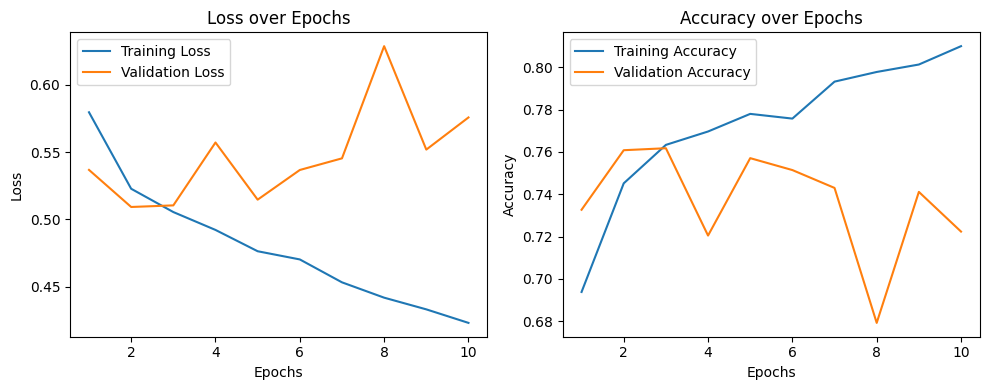

In [130]:
def collate_fn(batch):
    texts = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in texts], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<pad>'])
    return texts_padded.to(device), labels.to(device), lengths.to(device)

# Create datasets and dataloaders
batch_size = 32

train_data = RTDataset(train_dataset, vocab)
valid_data = RTDataset(validation_dataset, vocab)
test_data = RTDataset(test_dataset, vocab)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix ,bidirectional=False):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        # Pack padded sequences
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.rnn(packed_embedded)
        # hidden shape: [num_layers * num_directions, batch_size, hidden_dim]
        hidden = hidden[-1, :, :]  # Get the last layer's hidden state
        output = self.fc(hidden)
        return output

# Instantiate the model, loss function, and optimizer
hidden_dim = 448
output_dim = 2  # Negative or Positive sentiment

model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.00026641448147801634)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training and evaluation functions
def train(model, dataloader, optimizer, criterion):
    model.train()
    total_acc, total_loss = 0, 0
    for texts, labels, lengths in dataloader:
        #print(texts.device, labels.device, lengths.device)
        
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_acc += (outputs.argmax(1) == labels).sum().item()
        total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for texts, labels, lengths in dataloader:
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            total_acc += (outputs.argmax(1) == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    valid_acc, valid_loss = evaluate(model, valid_loader, criterion)
    
    # Store the losses and accuracies
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)
    
    print(f'Epoch {epoch + 1}:')
    print(f'    Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'    Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}')

# Evaluate on the test set
test_acc, test_loss = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()